In [1]:
import numpy as np
from numpy import *
from qutip import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

In [2]:
from modules.spin_arch import *
from modules.su_algebra import *

In [3]:
from IPython.display import Latex

In [4]:
Ntrunc = 3 #global operator for truncation level or total number of dimensions

In [5]:
#initialize system
N = 4
Nlevel = Ntrunc
omega=51
Ej, Ec, g_arr, omega = generate_tmon_arch(N,Nlevel,o=omega)
sys1 = tmon_system(N, Nlevel, Ec, Ej, g_arr, omega)
chi=2*(60-omega)/(57-omega)

In [6]:
sys1.freq_list()

[[0.0, 60.0, 117.0],
 [0.0, 60.0, 117.0],
 [0.0, 60.0, 117.0],
 [0.0, 60.0, 117.0]]

In [7]:
sys1.omega 

51

### Hamiltonian Evolution: $$e^{-iHt} \rho_0 e^{iHt}$$

In [8]:
a=1
b=np.sqrt(2)
c=1

# a=0.40824829
# b=0.70710678
# c=0.57735027
  

In [9]:
psi_2 = (a*basis(Nlevel,0) + b*basis(Nlevel,1) + c*basis(Nlevel,2))
psi_2 = psi_2/psi_2.norm()
psi_2 = psi_2 * psi_2.dag()
psi_2

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.25       0.35355339 0.25      ]
 [0.35355339 0.5        0.35355339]
 [0.25       0.35355339 0.25      ]]

In [10]:
H = sys1.H_I()
psi0 = tensor([psi_2]*N) #sys1.tensor_projection_op(0,1,1, dim = None)
unit=abs((H/(2*pi))[1,3])
times = np.linspace(0,2/unit,501) #time scale is ~ 1/freq of self energy 
options = Options()
options.store_final_state = True
result = mesolve(H, psi0, times, [], options = options, progress_bar=True)
# print(len(result.states))

51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
51 0.0 -0.3490658503988659
51 60.0 -1.0471975511965976
10.2%. Run time:   0.07s. Est. time left: 00:00:00:00
20.2%. Run time:   0.16s. Est. time left: 00:00:00:00
30.1%. Run time:   0.23s. Est. time left: 00:00:00:00
40.1%. Run time:   0.29s. Est. time left: 00:00:00:00
50.1%. Run time:   0.37s. Est. time left: 00:00:00:00
60.1%. Run time:   0.42s. Est. time left: 00:00:00:00
70.1%. Run time:

In [11]:
unit

0.1111111111111111

In [12]:
Sx=Qobj(ensemble_op(op_padded(Qobj(np.array([[0,1,0],[1,0,1],[0,1,0]])/np.sqrt(2)),Nlevel), N))
Sy=Qobj(ensemble_op(op_padded(Qobj(1j*np.array([[0,-1,0],[1,0,-1],[0,1,0]])/np.sqrt(2)),Nlevel), N))
Sz=Qobj(ensemble_op(op_padded(Qobj(np.array([[1,0,0],[0,0,0],[0,0,-1]])),Nlevel), N))

In [13]:
# pop_arr = []
# Jx_arr = []
# for i in tqdm(range(N)):
#     temp = []
#     temp2 = []
#     for state in result.states:
#         temp.append(abs(expect(state.ptrace(i), create(Nlevel)*destroy(Nlevel))))
#         temp2.append(abs(expect(state.ptrace(i),Qobj((op_padded(sigmax(),Nlevel))))))
#     pop_arr.append(temp)
#     Jx_arr.append(temp2)
#     #print(sum(temp))

In [14]:
pop_arr = []
Jx_arr = []
Jx2_arr = []

for state in result.states:
    pop_arr.append(abs(expect((state),tensor([create(Nlevel)*destroy(Nlevel)]*N))))
    Jx_arr.append((expect(state,Sx)))
    Jx2_arr.append((expect(state,Sx**2)))

    #print(sum(temp))

In [15]:
#Calculation of covariance matrix
# for now step (2,3) can be avoided as exact analytical results avaialble
# FI = n^T C n
def C_matrix(rho, J_arr):
    #do a dimension check for rho and J_arr[i] as well
    d = len(J_arr)
    C = np.zeros((d,d), dtype=complex)
    for i in range(d):
        for j in range(d):
            C[i][j] = 0.5*((rho*J_arr[i]*J_arr[j]).tr()+ (rho*J_arr[j]*J_arr[i]).tr())- (rho*J_arr[i]).tr()*(rho*J_arr[j]).tr()
    return C

def FI_max_cal(state_list, J_arr):
    FI_max_arr = []
    optimal_evec = []
    i = 0
    for state in tqdm(state_list):
        matrix = C_matrix(state, J_arr)
        eigenvalues, eigenvectors = np.linalg.eig(matrix)
        #temp_arr.append([str(i) + "time step: " + str(np.around(eigenvalues.real, 4))])
        #print(str(i) + "time step: " + str(np.around(eigenvalues.real, 4)))
        max_index = np.argmax(eigenvalues)
        max_eigenvalue = eigenvalues[max_index]
        max_eigenvector = eigenvectors[max_index]
        FI_max_arr.append(4*max_eigenvalue)
        optimal_evec.append(max_eigenvector)
        i = i+1
    
    return FI_max_arr, optimal_evec 
    

In [16]:
spin = 1
op_type = "gellmann"

if spin == 0.5:
    op_type = "pauli"
J_arr = gen_basisoperators(N, Nlevel, spin = spin, op_type =op_type) 

In [17]:
#Maximum Eigenvalue
#when n is the eigenvector with maximum eigen value of C, FI is maximized
# Define the matrix
def FI_max_cal(states, J_arr):
    FI_max_arr = []
    optimal_evec = []
    i = 0
    #temp_arr = []
    for state in tqdm(states):
        matrix = C_matrix(state, J_arr)
        eigenvalues, eigenvectors = np.linalg.eig(matrix)
        #temp_arr.append([str(i) + "time step: " + str(np.around(eigenvalues.real, 4))])
        #print(str(i) + "time step: " + str(np.around(eigenvalues.real, 4)))
        max_index = np.argmax(eigenvalues)
        max_eigenvalue = eigenvalues[max_index]
        max_eigenvector = eigenvectors[max_index]
        FI_max_arr.append(4*max_eigenvalue)
        optimal_evec.append(max_eigenvector)
        i = i+1
    return FI_max_arr, optimal_evec 

#FI_max_arr = FI_max_cal(result.states, J_arr)


In [18]:
# Plot for expectation values of the Gellman matrices
def exp_gell_op(states,J_arr):
    exp_gell_op=[]
    for i in tqdm(range(len(J_arr))):
        exp_gell_op.append(expect(states,J_arr[i]*(1)))
    return exp_gell_op

In [19]:
temp_arr = []
# temp_arr.append(exp_gell_op(result.states, gen_basisoperators(N, Nlevel, spin = 1, op_type ="pauli") ))
temp_arr.append(exp_gell_op(result.states, gen_basisoperators(N, Nlevel, spin = 1, op_type ="gellmann") ))
# # temp_arr.append(FI_max_cal(result.states, gen_basisoperators(N, Nlevel, spin = 1, op_type ="tensor") ))

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
# temp_arr = []
# temp_arr.append(FI_max_cal(result.states, gen_basisoperators(N, Nlevel, spin = 1, op_type ="pauli") ))
# temp_arr.append(FI_max_cal(result.states, gen_basisoperators(N, Nlevel, spin = 1, op_type ="gellmann") ))
# temp_arr.append(FI_max_cal(result.states, gen_basisoperators(N, Nlevel, spin = 1, op_type ="tensor") ))

In [21]:
# Plot for Fidelity
def Fidelity_cal(states,psi0=psi0):
    fid=[]
    for i in tqdm(states):
        fid.append(abs((i.dag()*psi0).tr()))
    return fid

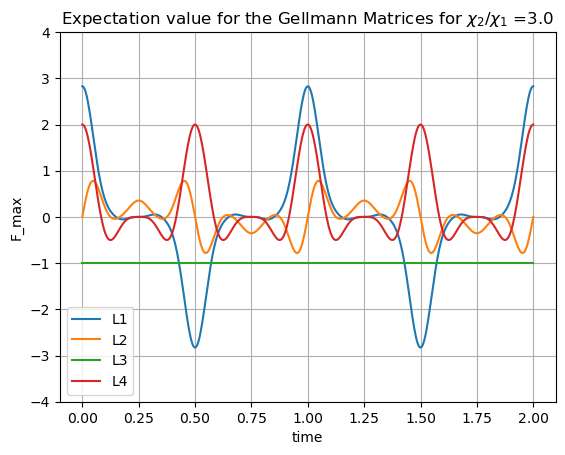

In [22]:
plt.plot(times*unit,transpose(temp_arr[0][0:4]) )
# plt.plot(times*unit,temp_arr[1][0])
# plt.plot(times,temp_arr[0][0],alpha = 0.5 )
# plt.plot(times,temp_arr[2][0],alpha = 0.5)
plt.title("Expectation value for the Gellmann Matrices for $\\chi_2/\\chi_1$ =" + str(round(chi,2)))
plt.xlabel("time")
plt.ylabel("F_max")
plt.grid()
plt.ylim(-4,4)
# plt.xlim([0,2])
plt.legend(["L1","L2","L3","L4","L5","L6","L7","L8"])
plt.show()

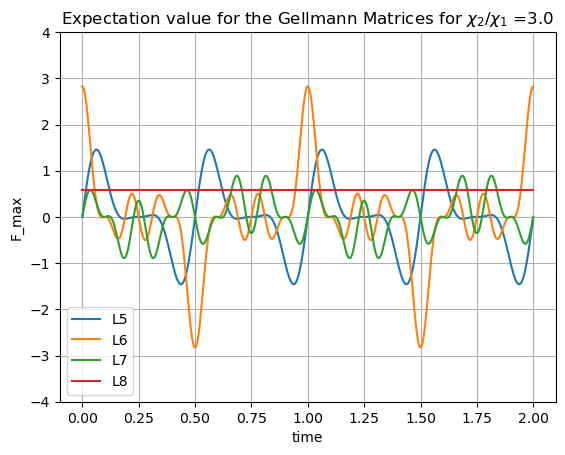

In [23]:
plt.plot(times*unit,transpose(temp_arr[0][4:]) )
# plt.plot(times*unit,temp_arr[1][0])
# plt.plot(times,temp_arr[0][0],alpha = 0.5 )
# plt.plot(times,temp_arr[2][0],alpha = 0.5)
plt.title("Expectation value for the Gellmann Matrices for $\\chi_2/\\chi_1$ =" + str(round(chi,2)))
plt.xlabel("time")
plt.ylabel("F_max")
plt.grid()
plt.ylim(-4,4)
# plt.xlim([0,2])
plt.legend(["L5","L6","L7","L8"])
plt.show()

In [24]:
len(temp_arr[0])

8

In [25]:
# plt.plot(times*unit,temp_arr[0][0] )
# plt.plot(times*unit,temp_arr[1][0])
# # plt.plot(times,temp_arr[0][0],alpha = 0.5 )
# # plt.plot(times,temp_arr[2][0],alpha = 0.5)
# plt.title("Fisher Information for " + str(N)+ " Spin 1/2 Transmons $\\chi_2/\\chi_1$ =" + str(round(chi,2)))
# plt.xlabel("time")
# plt.ylabel("F_max")
# plt.grid()
# # plt.ylim(10,70)
# # plt.xlim([0,2])
# plt.legend(["3 generators","8 gellmann generators", "8 tensor generators"])
# plt.show()

  0%|          | 0/501 [00:00<?, ?it/s]

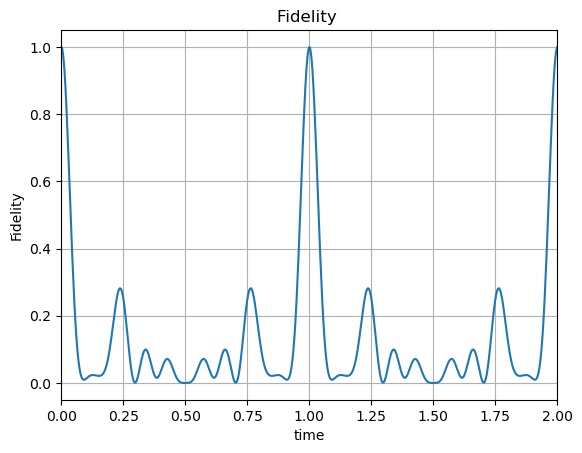

In [26]:
plt.plot(times*unit,Fidelity_cal(result.states) )
plt.title("Fidelity ")#for $\\chi_2/\\chi_1$ = " + str(round(chi,2)))
plt.xlabel("time")
plt.ylabel("Fidelity")
plt.grid()
# plt.ylim(10,70)
plt.xlim([0,2])
# plt.title("")
# plt.legend(["3 generators","8 gellmann generators", "8 tensor generators"])
plt.show()

In [27]:
def is_hermitian(matrix):
    return np.allclose(matrix, matrix.conj().T)

def cartesian_to_spherical(vec):
    """Converts a cartesian coordinate (x, y, z) into a spherical one (radius, theta, phi)."""
    x = vec[0]
    y = vec[1]
    z = vec[2]
    radius = np.sqrt(x * x + y * y + z * z)
    theta = math.atan2(np.sqrt(x * x + y * y), z)
    #theta = math.acos(z/radius)
    phi = math.atan2(y, x)
    return [radius, theta, phi]

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [28]:
#plot for optimal eigenvectors
spherical_coordinates = []
for vec in optimal_evec:
    spherical_coordinates.append(cartesian_to_spherical(vec.real))

NameError: name 'optimal_evec' is not defined

In [ ]:
spherical_coordinates = np.array(spherical_coordinates) 

In [ ]:
#plt.figure(figsize=(15,10))
plt.plot(times,spherical_coordinates[:,1], label  = "theta")
plt.plot(times,spherical_coordinates[:,2], label = 'phi')
plt.plot(times,FI_max_arr/max(FI_max_arr),alpha =0.5 , label = "FI_max rescaled", linestyle='dashed')
plt.title(str(N) + " tmon system, spin "+str(spin)+ ", with "+str(len(J_arr))+" "+ str(op_type)+" generators")
plt.xlabel("time")
plt.ylabel("angle in radians")
plt.legend()

In [ ]:
#Graph of FI vs time


In [ ]:
#(2)
#Encode \theta by applying U = e^{i n.J \theta}
psi_i = results.states #for FI vs time graph
n = np.array([1,0,0]) #ideally the max eigenvalue eigenvector
J_arr = np.array([]) #generators or their subset
theta_arr = np.linspace(0, 0.5, 2) #values of theta to encode
#code for n.J
result2 = mesolve(n*J_arr, psi_i, times, [], options = options)

In [ ]:
#Fisher Info Calculation
def purestate_FI(J,psi):
    FI = 4*variance(J,psi)
    return FI

In [ ]:
FI_list = []
for psi in result.states:
    FI_list.append(purestate_FI(H,psi))

plt.plot(times,FI_list)
plt.xlabel("time")
plt.ylabel("Finsher Info")

In [ ]:
#pauli operators for the tmon system
#initialize
N = 3 #number of transmons
Nlevel = Ntrunc
# spin = 1
# dim = spin*2+1

#padded operators
jx = op_padded(jmat(spin,'x'), Nlevel)
jy = op_padded(jmat(spin,'y'), Nlevel)
jz = op_padded(jmat(spin,'z'), Nlevel)
#combined spin operators
JX = 0
JY = 0
JZ = 0
for i in range(N):
    JX.append(ensemble_op(jx,i,N))
    JY.append(ensemble_op(jx,i,N))
    JZ.append(ensemble_op(jx,i,N))

In [ ]:
#calculate optimal squeezing parameter
H_cap = [] #array of all operators being considered
##calculate covariance matrix
##calculate commutator matrix
def calculate_covariance(matrix1, matrix2):
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")
    
    # Calculate the covariance
    covariance = np.cov(matrix1, matrix2, bias=True)
    
    return covariance

def covariance_matrix(H_cap):
    tau = np.zeros((len(H_cap),len(H_cap)))
    for k in range(len(H_cap)):
        for l in range(len(H_cap)):
            tau[k][l] = calculate_covariance(H_cap[k],H_cap(l))

In [ ]:
'''
#Hamiltonian for a set of transmons coupled to a mode
class tmon_system:
    def __init__(self,N, Nlevel, E_C, E_j, g_arr, omega):
        self.N = N #value of n goes from 0 to N-1
        self.Nlevel = Nlevel #cut off dimension/truncation
        #This is different from d which is the level that comes into hamiltonian.
        #d refers to the highest excitation present in the initialised state
        #d  by default is set to (Nlevel-2) as (d+1) at max can be (Nlevel-1)
        self.d = Nlevel-2
        self.E_c= E_c
        self.E_j = E_j
        self.g_arr = g_arr #g^n_i = g_arr[n][i]
        self.omega = omega #freq of photonic mode
        self.v_arr = self.freq_list() #v[n][i] = v^n_i
    
    def freq_list(self):
        #calculate v^n_i
        #for |i><i|_n, coefficient is  \sqrt(8E^n_j*E^n_c)*i - E^n_c/2*i(i+1)
        arr = []
        for n in range(self.N):
            temp_arr = []
            for i in range(self.d+1):
                v_ni = np.sqrt(8*self.E_c[n]*self.E_j[n])*i - 0.5*self.E_c[n]*i*(i+1)
                temp_arr.append(v_ni)
            arr.append(temp_arr) 
        return arr
    
    def cal_delta(self):
        #simplest version is to equate to average over transmons i.e n
        delta_arr = []
        
        for n in range(self.N):
            temp = 0
            for i in range(self.d +1):
                temp = temp + ((self.g_arr[n][i]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]-self.omega)+self.v_arr[n][i])
            delta_arr.append(temp/(self.d+1))
        return delta_arr
    
    def tensor_id(self, dim = None):
        if dim ==None:
            dim = self.d+2
        #IxIxIxI...Ioperator
        Neye = []
        for i in  range(self.N):
            Neye.append(qeye(dim))
        nid = tensor(Neye)
        return nid
          
    def tensor_projection_op(self,n,i,j, dim = None):
        #returns IxIxIx...(|i><j|_n)xIxI...xI
        if n > self.N-1:
            print("invalid n")
            return
        if dim ==None:
            dim = self.d+2
            
        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(dim))
        #(|i><j|_n)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def H_I(self, delta_arr = None):
        #rotataed time indp effective hamiltonian
        #lambda_arr contains \Delta_i to be added as self energy corrections
        if delta_arr==None:
            delta_arr = self.cal_delta()
        
        H0 = 0
        for n in range(self.N):
            for i in range(self.d + 1):
                c_ni = (self.g_arr[n][i-1]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]- self.omega) + self.v_arr[n][i] - delta_arr[i]
                H0 = H0 + c_ni*self.tensor_projection_op(n,i,i)
        
        H1 = 0
        for n in range(self.N):
            for m in range(self.N):
                for i in range(self.d + 1):
                    if n == m:
                        break
                    c_nmi = 0.5*(self.g_arr[n][i]*self.g_arr[m][i])/(self.omega - self.v_arr[m][i])
                    H1 = H1 + c_nmi*(self.tensor_projection_op(n,i,i+1)*self.tensor_projection_op(m,i+1,i) + self.tensor_projection_op(n,i+1,i)*self.tensor_projection_op(m,i,i+1))
        
        return H0 + H1

def generate_tmon_arch(N,Nlevel):
    #scaling is 1 to 100MHz
    E_j =  np.absolute(np.random.normal(200,20, N))
    E_c = np.absolute(np.random.normal(2.5,0.2, N))
    g_arr = np.zeros((N,Nlevel))
    for n in range(N):
        for i in range(Nlevel):
            g_arr[n][i] = 1
    omega = 2
    return E_j, E_c, g_arr,omega 
'''

In [ ]:
"""
#create spin operators
class operators:
    def __init__(self, N, spin):
        self.N = N
        self.spin =spin
        
    
    def generators_arr(self):
        #return all generators for a spin-n algebra
        return
    
    def tensor_operator(self,op,i):
        #returns IxIxIx...(op_i)xIxI...xI
        if i > self.N-1:
            raise ValueError("index needs to be between 0 and"+str(self.N)+"-1")

        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(self.spin))
        #(op_i)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def J_n(self,n):
        #\sum (n.J)_i
        #it should take both 3x1 and dx1 vectors
        #3x1 leads to use of just sigma x,y,z
        #dx1 leads to use of all generators
        jx = jmat(i, 'x')
        jy = jmat(i, 'y')
        jz = jmat(i, 'z')
        
        
     
    def nonlin_operators(self, degree):
        #take array of generators and combine them to get non-lin operators
        #return vector with non-lin operators only
        lin_op_arr = self.generators_arr
        nonlin_arr = []
"""

In [ ]:
from numpy import *
from qutip import *

In [ ]:
arr=array([[0,1,0],[1,0,sqrt(1)],[0,sqrt(1),0]])
Qobj(arr).eigenstates()[1][1]

In [ ]:
8.62-2*4.65